# Sentiment Analysis of the Reviews
Now, we also want our system to have a sentiment analysis segement as well. Therefore, we will be ingesting data into out file, from which we can get the reviews and train our system to assess correctly whether a review is positive or negative. As we go ahead, we would also like a functionality where the user can select to see how highly a movie is rated based on it's reviews.

## Importing the Dependencies


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes

from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

import nltk

## Loading the Data

In [3]:
data = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Here, the **sentiment** column describes the sentiment of the review, either positive or negative. While, the **review** column shows the actual comment.

In [4]:
# Number of Reviews
data.shape[0]

50000

## EDA
Let us do some EDA to get a quick view of how exactly our data looks.

In [5]:
data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Let us try to get a visual comparision.

<Axes: title={'center': 'Count of Type Of Reviews'}, xlabel='sentiment'>

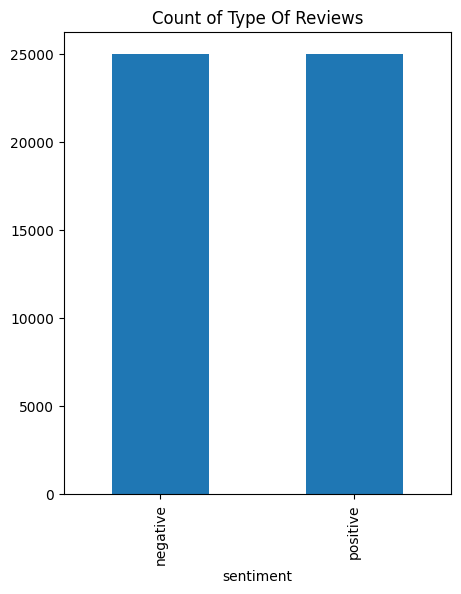

In [6]:
data['sentiment'].value_counts().sort_index().plot(kind='bar',title="Count of Type Of Reviews",figsize=(5,6))

Here this gives us an idea that the data is not imbalanced or biased towards one kind of reviews, rather it is perfectly balanced. So, we can proceed ahead with this data. 

## VADER (Valence Aware Dictionary and Sentiment Reasoner) 
Now, this is basically a s a lexicon and rule-based sentiment analysis tool that is specifically designed for sentiments expressed in social media, but it's versatile enough to use in various contexts, including movie reviews. This uses a bag of words approach where:

* The stop words are removed
* Each word is scored seperatly and combined to a total score in the end

An important thing to note is that this apporach **does not** account for the relationship between words, which is a very important factor.

So, we go start with this and see what kind of results are we getting, comapre them to other approches and chossing the best possible outcome.

In [11]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [13]:
SIA = SentimentIntensityAnalyzer()

Let us now go ahead and run it on the entire data

In [14]:
def get_compounded(text):
    return SIA.polarity_scores(text)['compound']
    

In [15]:
data['polarity_scores'] = data['review'].apply(get_compounded)

In [16]:
def categorize_polarity(score):
    if score <= 0.05:
        return "negative"
    else:
        return "positive"

data['sentiment_vader'] = data['polarity_scores'].apply(categorize_polarity)

In [17]:
data = data[['review','sentiment','sentiment_vader']]

In [18]:
data.head()

,review,sentiment,sentiment_vader
0,One of the other reviewers has mentioned that ...,positive,negative
1,A wonderful little production. <br /><br />The...,positive,positive
2,I thought this was a wonderful way to spend ti...,positive,positive
3,Basically there's a family where a little boy ...,negative,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,positive


### Model Accuracy Check - VADER
Let us now check how accurate our model based on vader predicts.

In [19]:
accuracy = accuracy_score(data['sentiment'], data['sentiment_vader'])
print("Accuracy is: ",accuracy*100,"%")

Accuracy is:  69.55799999999999 %


Thus, we can clearly see that although it does predict our reviews, it does not exactly have a good score and certainly we could improve. Let us have a look at the confusion matrix.

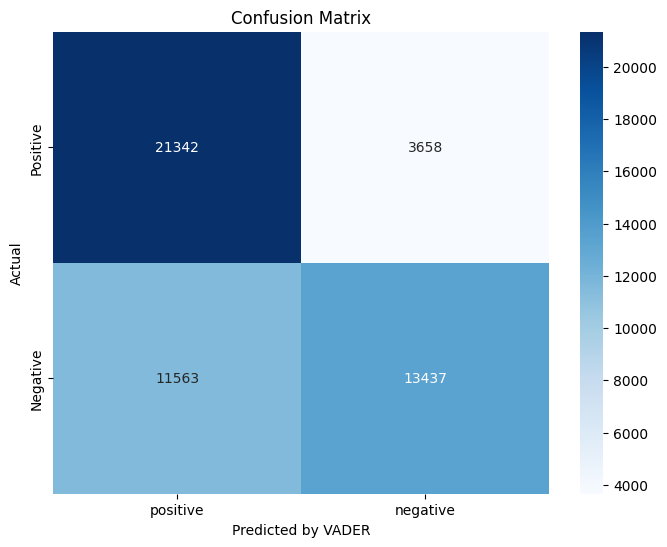

In [21]:
cm = confusion_matrix(data['sentiment'], data['sentiment_vader'], labels=["positive", "negative"])

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["positive", "negative"], yticklabels=["Positive", "Negative"])
plt.ylabel('Actual')
plt.xlabel('Predicted by VADER')
plt.title('Confusion Matrix')
plt.show()

So here, we can see some very interesting observations.

* The model is able to precit **85.368 %** (21342/25000) of the total positive reviews. That shows that the model correctly is able to get the vast majority of the positive reviews (of course with room for improvement)

* However, it is only able to get **53.748 %** (13437/250000) of the total negative reviews, making huge errors in the portion where the reviews were actually negative but the model predicts them as positive i.e. it has a high number of *False Positives* 

* Therefore, the model's overall performance lacks in the classification of negative reviews.

Seeing this, we should try to understand why this is not performing well on the negative reviews as much as the positive. One factor where I feel where the model lacks is:

* Lack of Contextual Understanding and Relationship between words
    * Since the model is not taking the context and relationship between the words into account, it significantly is not able to grasp the negative reviews. 
    * Many negative reviews may have some negations which are left unhandled.  For instance,("not good" should be negative but system sees it as positive) or misinterpreting sarcasm can lead to false predictions.
    
We should try another model which can predict it with high accuracy.

## Multi Nomial Bayes
Let us now check for multinomial bayes, although it is a basic model and is no where near the deep learning SOTA models like Roberta, we do this analysis just to be sure.

In [66]:
# Creating Stopwords
stopset = stopwords.words('english')

In [67]:
vectorizer = TfidfVectorizer(use_idf = True,lowercase = True, strip_accents='ascii',stop_words=stopset)

In [68]:
x = vectorizer.fit_transform(data['review'])
y = data['sentiment']

Now let us divide the data into training and test data for further analysis.

In [69]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [70]:
# Initialising the Model
model_mb = naive_bayes.MultinomialNB()
model_mb.fit(X_train,y_train)

MultinomialNB()

### Model Accuracy Check - Multi Nomial Bayes
Let us now check how accurate our model based on multi nomial bayes predictions.

In [71]:
print("Accuracy on model trained on training data is: ",accuracy_score(y_test,model_mb.predict(X_test))*100,"%")

Accuracy on model trained on training data is:  86.59 %


Let us now fit it on the entire model.

In [72]:
model_mb1 = naive_bayes.MultinomialNB()
model_mb1.fit(x,y)

MultinomialNB()

In [73]:
print("Accuracy on model trained on training data is: ",accuracy_score(y_test,model_mb1.predict(X_test))*100,"%")

Accuracy on model trained on training data is:  90.48 %


Thus, we can see that although it is a much better accurate prediction of the reviews, we could further improve on this by using SOTA (State of the Art) deep learning models which will help us immensely.

## Roberta PreTrained Model
RoBERTa (Robustly optimized BERT approach) is a variant of BERT that was developed by Facebook AI. It's designed to be more robust than the original BERT model by modifying the training methodology and training on more data.

Let us try to use that and see how well it performs. We will take the **aychang/roberta-base-imdb** model as our base, as it is a RoBERTa model specifically fine-tuned on the IMDB dataset, which is a set of movie reviews labeled as positive or negative.


In [22]:
MOD = f"aychang/roberta-base-imdb"
tokenizer = AutoTokenizer.from_pretrained(MOD)
model = AutoModelForSequenceClassification.from_pretrained(MOD)

So basically here, we are taking the pre trained weights from a model which has labelled twitter sentiment analysis and using them directly on our data.

In [38]:
model.to('cuda') # Shifting the model to GPU

def sentiment_pred_roberta(text):
    encoded_text = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to('cuda')
    output = model(**encoded_text)
    # Convert tensor to numpy after moving it back to CPU
    scores = output[0][0].detach().cpu().numpy()
    
    scores = softmax(scores)

    max_index = np.argmax(scores)

    if max_index == 0:
        sentiment = 'negative'
    elif max_index == 1:
        sentiment = 'positive'

    return sentiment


In [39]:
data['polarity_scores_roberta'] = data['review'].apply(sentiment_pred_roberta)

In [41]:
data = data.rename(columns={'polarity_scores_roberta':'sentiment_roberta'})

### Model Accuracy Check - Roberta
Let us now check how accurate our model based on roberta predicts.

In [43]:
accuracy_roberta = accuracy_score(data['sentiment'], data['sentiment_roberta'])
print("Accuracy is: ",accuracy_roberta*100,"%")

Accuracy is:  96.482 %


Thus, we can clearly see that it does predict our reviews with much better accuracy, as compared to our previous model. Let us also have a look at the confusion matrix.

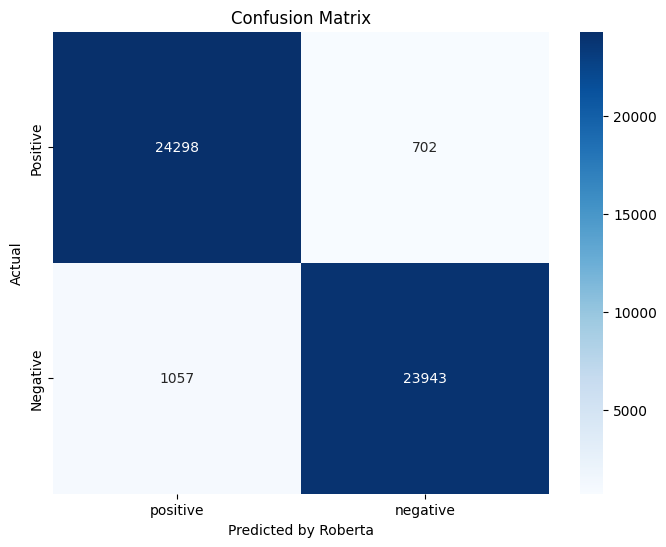

In [74]:
cm = confusion_matrix(data['sentiment'], data['sentiment_roberta'], labels=["positive", "negative"])

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["positive", "negative"], yticklabels=["Positive", "Negative"])
plt.ylabel('Actual')
plt.xlabel('Predicted by Roberta')
plt.title('Confusion Matrix')
plt.show()

So here, we can observe that:

* The model is able to precit **97.192 %** (24298/25000) of the total positive reviews. That shows that the model correctly is able to get the vast majority of the positive reviews.

* However, it is only able to get **95.772 %** (23943/250000) of the total negative reviews. That shows that the model correctly is able to get the vast majority of the negative reviews.

* Therefore, the model's overall performance is quite decent in the classification of positive and negative reviews.

## Conclusion
Thus, we can now confidently say that it would be much better to use the Roberta model, as comapred to the other two. Thus, we can go ahead and rely on Roberta model (with the base as **aychang/roberta-base-imdb**) to give our sentiment analysis.